#Problem Statement 

Image captioning has various applications  in virtual assistants, for image indexing, for visually impaired persons, for social media, and several other natural language processing applications. 
For a scientific project Generating captions for images can become a tedious task and take years to complete.
PS: Develop a system that can Automatically generate captions for a given image.

# DataSets and Inputs
The dataset used for this project is “Flickr8K” dataset[3].
Flickr8K dataset  includes images obtained from the Flickr website.
It is a labeled dataset consisting of 8000 photos.
This dataset is suitable for the project because there are  5 captions for each photo.




# Solution Statement
Apply Deep Learning Techniques to develop an image captioning model that can automatically develop captions for a given image.
We will use a combination of CNN(Convolutional Neural Network) and RNN(Recurrent Neural Network) to develop this system.
First we will extract features of the image by using CNN , and then we will feed this feature vector to a LSTM language model that will generate captions.
Thus we will have a CNN Encoder and a LSTM Decoder.(LSTM is a special kind of RNN, capable of learning long-term dependencies)
We will also use pre-trained models on standard Imagenet dataset(provided in keras) to develop the CNN encoder.

In [3]:
# Imports 

## For uploading dataset 

import os 
from google.colab import drive

from google.colab import files

## for CNN_Encoder (Feature extrator model)

from pickle import dump
from os import listdir
import string
import numpy as np 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model


from numpy import array
import tensorflow as tf
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint

## 

# Step 1: Downloading the required dataset 

In [ ]:
###################### Mounting the drive ##############################

drive.mount('/content/gdrive')

####################### Uploading the kaggle API key ###################

files.upload() #this will prompt you to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

####################### Downloading the dataset ########################

!kaggle datasets download -d shadabhussain/flickr8k

os.chdir('/content')  #change dir
!mkdir Flicker8k_Dataset  #create a directory 
!unzip -q flickr8k.zip -d Flicker8k_Dataset

os.listdir('/content/Flicker8k_Dataset/')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle.json
kaggle.json
 99% 2.11G/2.13G [00:14<00:00, 180MB/s]
100% 2.13G/2.13G [00:14<00:00, 160MB/s]


['flickr_data', 'model_weights.h5', 'Flickr_Data', 'train_encoded_images.p']

# Step2 : Data Preprocessing 
Since the Flickr8K dataset contains 8000 different photos with 5 descriptions for each photo. The preprocessing will involve both processing of images as well texts.  
We will first develop a feature extractor using transfer Learning(VGG19 model) to extract features from the images and save them in a .pkl file.
Then we will move towards text processing, we will start with loading and cleaning the descriptions ( tokenization , converting to lowercase, removing punctuation, etc) and then save the cleaned descriptions in a .txt file. We will also create a vocabulary consisting of all the words in the descriptions.


# A:  Clean & Process the Data 

In [4]:

def process_img(filename):

  image = load_img(filename, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the VGG model
  image = preprocess_input(image)

  return image 

def extract_features(directory):

  # Prepare the model 

  model = VGG16()
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  print(model.summary())


  # extract features from each photo
  features = dict()
  for name in listdir(directory):
  
    image_id = name.split('.')[0]
    filename = directory + '/' + name


    image = process_img(filename)
    feature = model.predict(image, verbose=0)

    
    # store feature
    features[image_id] = feature
    print("extracted ........1 ")
  return features


# extract descriptions for images
def load_descriptions(filename):

  file = open(filename, 'r')
  doc = file.read()
  file.close()

  mapping = dict()

  for line in doc.split('\n'):
 
    tokens = line.split()
    if len(line) < 2:
      continue
 
    image_id, image_desc = tokens[0], tokens[1:] #first token is the image id, the rest is the description
    image_id = image_id.split('.')[0]
    image_desc = ' '.join(image_desc)

    if image_id not in mapping:
      mapping[image_id] = list()
 
    mapping[image_id].append(image_desc)
  return mapping
 
def clean_descriptions(descriptions):
 
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1] # removing short words 
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
 
			desc_list[i] =  ' '.join(desc)
 
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 

In [5]:
#extract features from all images
directory = '/content/Flicker8k_Dataset/Flickr_Data/Flickr_Data/Images'
#features = extract_features(directory)
#print('Extracted Features: %d' % len(features))
# save to file
#dump(features, open('features.pkl', 'wb'))

In [6]:

filename = '/content/Flicker8k_Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
 
# parse descriptions
descriptions = load_descriptions(filename)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')




Loaded: 8092 
Vocabulary Size: 8763


# B: Create treaning and testing data 

In [7]:

 
def load_file(filename):
	file = open(filename, 'r')

	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_file(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_file(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 

In [8]:

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)
 


In [9]:
# train dataset
 
# load training dataset 
filename = '/content/Flicker8k_Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/gdrive/My Drive/Imagecap/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/content/gdrive/My Drive/Imagecap/features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/gdrive/My Drive/Imagecap/tokenizer.pkl', 'wb'))

word_index  = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)
 
# dev dataset
 


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [10]:
# load test set
filename = '/content/Flicker8k_Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/content/gdrive/My Drive/Imagecap/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/gdrive/My Drive/Imagecap/features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


# Glove Embeddings 
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

We are going to use a GloVe pretrained corpus model to represent our words, trained on Twitter data (2B tweets, 27B tokens, 1.2M vocab).

It is available in 3 varieties : 50D, 100D and 200 Dimentional. Since we are using Colab, We will try 200D here.

Link:https://nlp.stanford.edu/projects/glove/

In [11]:
# Step 1
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

# Step 2 

#import zipfile
#zip_ref = zipfile.ZipFile("/content/glove.twitter.27B.zip", 'r')
#zip_ref.extractall("/content/gdrive/My Drive/Colab-Datasets") # a location in drive
#zip_ref.close()


# since we are using 200D Glove embeddings trianed on twitter data 

Glove_twitter_200D_path = "/content/gdrive/My Drive/Colab-Datasets/glove.twitter.27B.200d.txt"

In [12]:
embedding_dict = {}
with open(Glove_twitter_200D_path, "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [13]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 200))


for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

# Step 3: Define a Model 



In [14]:
import tensorflow

# fit model
def define_model(vocab_size, max_length):
    # feature extractor model

    inputs1 = Input(shape=(1000,))

    i1_1 = Dense(256, activation='relu')(inputs1)

    i1_1 = Dropout(0.1)(i1_1)
    i1_2 = Dense(128, activation='relu')(i1_1)

    # sequence model

    inputs2 = Input(shape=(max_length,))

    i2_1 = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable = False  )(inputs2)

    i2_1 = Dropout(0.1)(i2_1)
    i2_2 = Dense(128, activation='relu')(i2_1)
    
    #addition  layer
    
    merge = tf.keras.layers.add([i1_2, i2_2]) 

    #language model
    lm_1 = LSTM(128 , return_sequences= True )(merge)
    lm_2 = LSTM(64)(lm_1)

    #fully connected

    lm_d_1 = Dense(128, activation='relu')(lm_2)
    bn_d_1 = BatchNormalization()(lm_d_1)
    do_d_1 = Dropout(0.2)(bn_d_1)


    lm_d_2 = Dense(256, activation='relu')(do_d_1)
    bn_d_2 = BatchNormalization()(lm_d_2)
    do_d_2 = Dropout(0.2)(bn_d_2)


    lm_d_3 = Dense(512, activation='relu')(do_d_2)
    bn_d_3 = BatchNormalization()(lm_d_3)
    do_d_3 = Dropout(0.2)(bn_d_3)

    #output layer 

    outputs = Dense(vocab_size, activation='softmax')(do_d_3)

 

    model = Model(inputs=[inputs1, inputs2], outputs=outputs) #[image, seq] [word]

    return model



#with strategy.scope():
model = define_model(vocab_size, max_length)#Build your model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
print(model.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          256256      input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      1515800     input_2[0][0]                    
_______________________________________________________________________________________

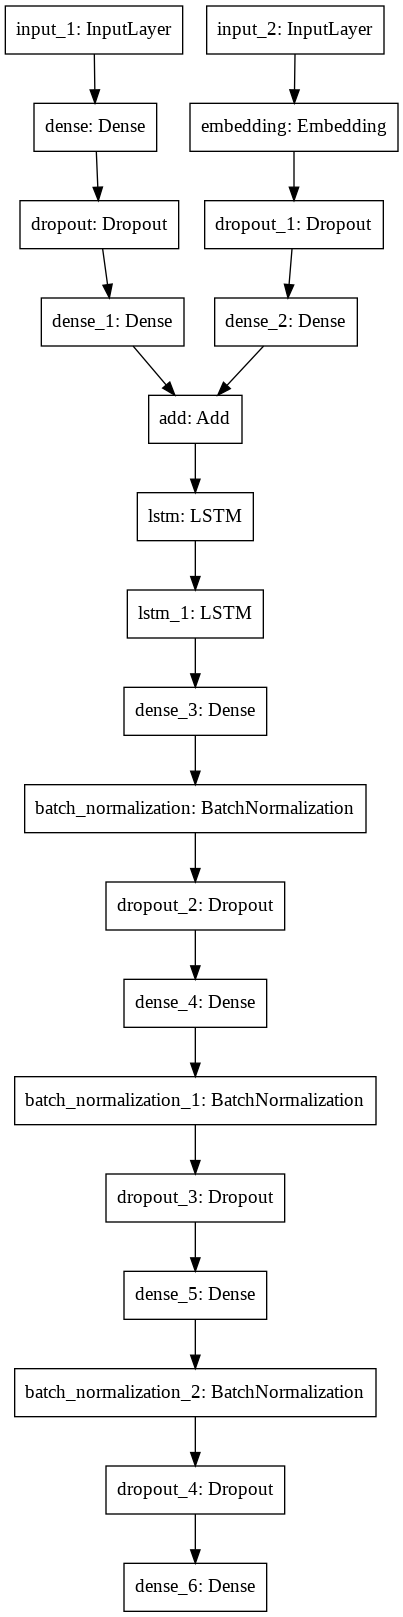

In [15]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
 
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [16]:
model.fit([X1train, X2train], ytrain, epochs=10, verbose=2,validation_data=([X1test, X2test], ytest))



Epoch 1/10
9576/9576 - 587s - loss: 4.4405 - val_loss: 3.8810
Epoch 2/10
9576/9576 - 553s - loss: 3.8690 - val_loss: 3.6907
Epoch 3/10
9576/9576 - 550s - loss: 3.6866 - val_loss: 3.6034
Epoch 4/10
9576/9576 - 542s - loss: 3.5802 - val_loss: 3.5821
Epoch 5/10
9576/9576 - 540s - loss: 3.5022 - val_loss: 3.5650
Epoch 6/10
9576/9576 - 546s - loss: 3.4469 - val_loss: 3.5590
Epoch 7/10
9576/9576 - 541s - loss: 3.3992 - val_loss: 3.5466
Epoch 8/10
9576/9576 - 546s - loss: 3.3602 - val_loss: 3.5481
Epoch 9/10
9576/9576 - 544s - loss: 3.3256 - val_loss: 3.5499
Epoch 10/10
9576/9576 - 547s - loss: 3.2965 - val_loss: 3.5576


In [18]:
model.save('saved_model_26_10_2020_No_of_epochs_10')
!zip -r "/content/saved_model_26_10_2020_No_of_epochs_10.zip" "/content/saved_model_26_10_2020_No_of_epochs_10/"


INFO:tensorflow:Assets written to: saved_model_26_10_2020_No_of_epochs_10/assets
updating: content/saved_model_26_10_2020_No_of_epochs_10/ (stored 0%)
updating: content/saved_model_26_10_2020_No_of_epochs_10/saved_model.pb (deflated 89%)
updating: content/saved_model_26_10_2020_No_of_epochs_10/variables/ (stored 0%)
updating: content/saved_model_26_10_2020_No_of_epochs_10/variables/variables.index (deflated 72%)
updating: content/saved_model_26_10_2020_No_of_epochs_10/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/saved_model_26_10_2020_No_of_epochs_10/assets/ (stored 0%)
cp: -r not specified; omitting directory '/content/saved_model_26_10_2020_No_of_epochs_10'


In [19]:
!cp "/content/saved_model_26_10_2020_No_of_epochs_10.zip" "/content/gdrive/My Drive/Colab-Datasets"

# Model Evaluation

In [22]:


from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
 
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
 

BLEU: 0.556546
